In [1]:
import matplotlib.pyplot as plt

from skferm.datasets import load_mtp_ph_data, load_rheolaser_data
from skferm.plotting import plot_fermentation_curves
from skferm.smoothing import SMOOTHING_METHODS, smooth, smooth_sequential

# Configure matplotlib for lower resolution plots (better for version control)
plt.rcParams["figure.dpi"] = 72  # Lower DPI (default is usually 100)
plt.rcParams["savefig.dpi"] = 72  # Lower save DPI
plt.rcParams["figure.figsize"] = (10, 6)  # Smaller default figure size

%load_ext autoreload
%autoreload 2

# Curve Smoothing Demo

This notebook demonstrates how to smooth a noisy curve using several methods within the `skferm.smoothing` module.


# Rheolaser Dataset

The Rheolaser dataset contains elasticity index measurements over time from fermentation experiments. This data comes from a Rheolaser instrument and provides insights into the rheological properties of fermenting cultures.

In [2]:
# Load cleaned data in long format (recommended)
rheolaser_data = load_rheolaser_data(clean=True)

rheolaser_data.head()

,sample_id,time,elasticity_index
0,A1,0.000000,0.368
1,A1,1.033333,0.334
2,A1,2.066667,0.340
3,A1,3.100000,0.374
4,A1,4.133333,0.344


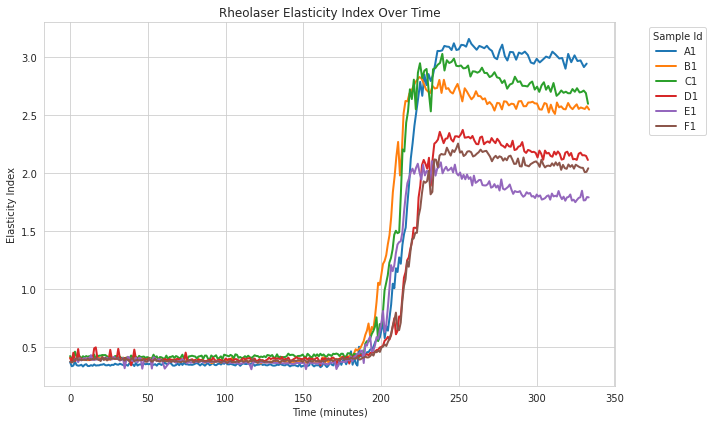

In [3]:
# Test the plotting function
fig = plot_fermentation_curves(
    rheolaser_data,
    title="Rheolaser Elasticity Index Over Time",
    x="time",
    y="elasticity_index",
    xlabel="Time (minutes)",
    ylabel="Elasticity Index",
)
plt.show()

# Smoothing

We will apply different smoothing techniques to the elasticity index data to reduce noise and highlight underlying trends. The available methods include:

- Exponential Moving Average (EMA), `method='ema'`
- Rolling Mean, `method='rolling'`
- Savitzky-Golay Filter, `method='savgol'`

Rolling mean will be the default method if none is specified.

You can also extend the API with you own smoothing method (Callable), as long as it follows the same input/output conventions. You can use `apply_method_to_groups` from core for this. 

Notice that the smoothing methods are applied per group, if a `groupby_col` is provided.

In [4]:
# available smoothing methods
SMOOTHING_METHODS

{'rolling': <function skferm.smoothing.methods.rolling_average(df: pandas.core.frame.DataFrame, x: str, y: str, window: int = 5, center: bool = True, **kwargs) -> pandas.core.frame.DataFrame>,
 'ema': <function skferm.smoothing.methods.exponential_moving_average(df: pandas.core.frame.DataFrame, x: str, y: str, span: int = 10, **kwargs) -> pandas.core.frame.DataFrame>,
 'savgol': <function skferm.smoothing.methods.savitzky_golay_smooth(df: pandas.core.frame.DataFrame, x: str, y: str, window_length: int = 5, polyorder: int = 2, **kwargs) -> pandas.core.frame.DataFrame>}

In [5]:
# smooth defaults are: method="rolling", window_size=5
smoothed_data = smooth(rheolaser_data, x="time", y="elasticity_index", groupby_col="sample_id")

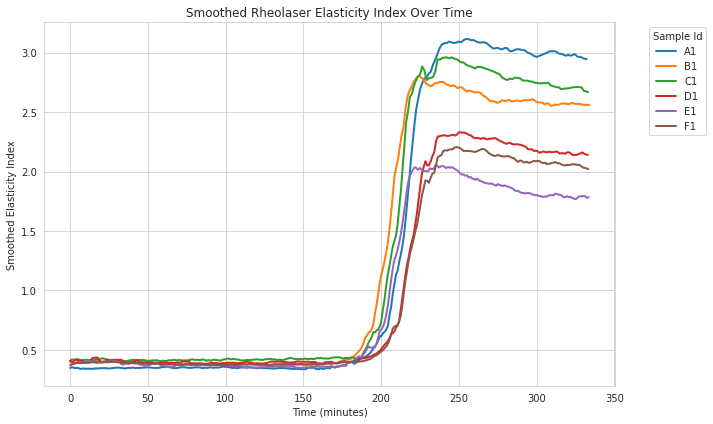

In [6]:
fig = plot_fermentation_curves(
    smoothed_data,
    title="Smoothed Rheolaser Elasticity Index Over Time",
    x="time",
    y="elasticity_index_smooth",
    xlabel="Time (minutes)",
    ylabel="Smoothed Elasticity Index",
)

So a lot less noisy, but still some fluctuations.

# Sequential Smoothing 

Also called "cascaded filtering" or "multi-stage smoothing", this technique involves applying multiple smoothing methods in sequence to achieve a more refined result. Each method can target different types of noise or fluctuations in the data.

The smoothing API can be easily chained using the pandas `pipe` operator to apply multiple smoothing methods in sequence.

Pros:
- Improved noise reduction: Each stage removes different frequency components
- Controlled edge preservation: Different methods can preserve different signal characteristics
- Flexibility: Can combine complementary smoothing approaches

Cons:
- Over-smoothing risk: Can remove important signal features and introduce artifacts
- Phase distortion: Multiple passes can shift signal timing
- Parameter dependency: Results become sensitive to the order and parameters of operations

Best Practices:
- Use different smoothing methods in sequence (e.g., EMA → Rolling → EMA)
- Decrease window sizes in later stages
- Monitor signal-to-noise ratio to avoid over-smoothing
- Consider single-pass methods with adaptive parameters first

In [7]:
smoothed_data = (
    rheolaser_data.copy()
    .pipe(smooth, x="time", y="elasticity_index", groupby_col="sample_id", method="ema", window_size=50)
    .pipe(smooth, x="time", y="elasticity_index_smooth", groupby_col="sample_id", method="rolling", window_size=20)
    .drop(columns=["elasticity_index_smooth"])
    .rename(columns={"elasticity_index_smooth_smooth": "elasticity_index_smooth"})
    .pipe(smooth, x="time", y="elasticity_index_smooth", groupby_col="sample_id", method="ema", window_size=11)
    .drop(columns=["elasticity_index_smooth"])
    .rename(columns={"elasticity_index_smooth_smooth": "elasticity_index_smooth"})
)

Now this works, but looks a bit ridiculous. Therefore, you can also use the smooth_sequential api. Here we have to define stages as a list of tuples, where each tuple contains the method name and its parameters.

In [8]:
smoothed_data = smooth_sequential(
    rheolaser_data,
    x="time",
    y="elasticity_index",
    groupby_col="sample_id",
    stages=[
        ("rolling", {"window_size": 2}),
        ("rolling", {"window_size": 4}),
    ],
)

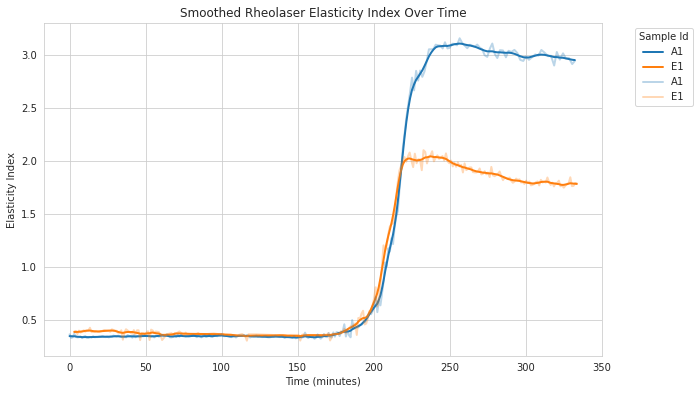

In [9]:
fig, ax = plt.subplots()

plot_fermentation_curves(
    smoothed_data.loc[lambda d: d["sample_id"].isin(["A1", "E1"])],
    title="Smoothed Rheolaser Elasticity Index Over Time",
    x="time",
    y="elasticity_index_smooth",
    xlabel="Time (minutes)",
    ylabel="Elasticity Index",
    ax=ax,
)
plot_fermentation_curves(
    rheolaser_data.loc[lambda d: d["sample_id"].isin(["A1", "E1"])],
    title="Smoothed Rheolaser Elasticity Index Over Time",
    x="time",
    y="elasticity_index",
    xlabel="Time (minutes)",
    ylabel="Elasticity Index",
    ax=ax,
    alpha=0.3,
);

# Be careful!

Smoothing can go wrong, so please be careful and always visualize your results! I you overdo it, or pick the wrong method, you can easily introduce artifacts or remove important features from your data.

If for the example above we instead used a Exponential Moving Average (EMA) followed by a rolling mean with a window that's to big, we get a complete shift in the curve, which might not be what we want.

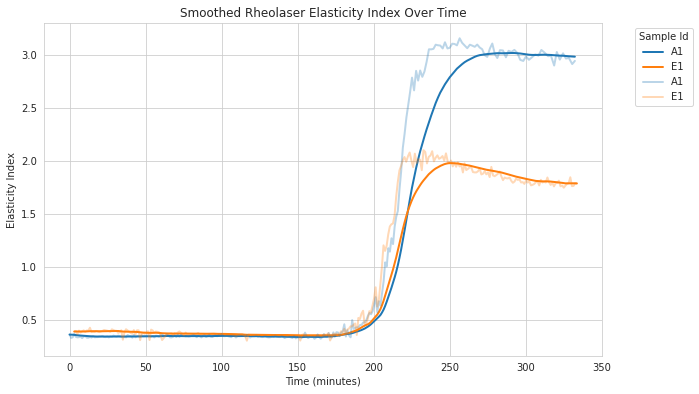

In [10]:
smoothed_data = rheolaser_data.copy().pipe(
    smooth_sequential,
    x="time",
    y="elasticity_index",
    groupby_col="sample_id",
    stages=[
        ("ema", {"span": 20}),
        ("rolling", {"window_size": 5}),
    ],
)

fig, ax = plt.subplots()

plot_fermentation_curves(
    smoothed_data.loc[lambda d: d["sample_id"].isin(["A1", "E1"])],
    title="Smoothed Rheolaser Elasticity Index Over Time",
    x="time",
    y="elasticity_index_smooth",
    xlabel="Time (minutes)",
    ylabel="Elasticity Index",
    ax=ax,
)
plot_fermentation_curves(
    rheolaser_data.loc[lambda d: d["sample_id"].isin(["A1", "E1"])],
    title="Smoothed Rheolaser Elasticity Index Over Time",
    x="time",
    y="elasticity_index",
    xlabel="Time (minutes)",
    ylabel="Elasticity Index",
    ax=ax,
    alpha=0.3,
);

## Smoothing Metrics

Besides always checking your smoothing results visually, you can also use some metrics to quantify the amount of smoothing. Some common metrics are:
- Total Variation: Widely used in image denoising (Rudin et al., 1992) and adapted for time series
- MSSD: Common in biomedical signal analysis for heart rate variability
- Roughness Penalty: Foundation of smoothing splines (Wahba, 1990)
- Spectral Methods: Standard in digital signal processing (Oppenheim & Schafer)

It's good to log some of the metrics depending on your data processing workflow for your fermentation data. For the example below we want to make sure the smoothed data is close to the original data, but also has a lower total variation.

In [11]:
from skferm.smoothing import evaluate_smoothing_quality

Let's demonstrate these metrics with both good and bad smoothing examples. We'll use the same data from earlier in the notebook.

### Good Smoothing Example
First, let's look at the "good" smoothing example with rolling windows:

In [12]:
# Good smoothing example - rolling windows
good_smoothed_data = smooth_sequential(
    rheolaser_data,
    x="time",
    y="elasticity_index",
    groupby_col="sample_id",
    stages=[
        ("rolling", {"window_size": 2}),
        ("rolling", {"window_size": 4}),
    ],
)

evaluate_smoothing_quality(
    good_smoothed_data,
    x_col="time",
    smoothed_col="elasticity_index_smooth",
    original_col="elasticity_index",
    group_col="sample_id",
)

,sample_id,elasticity_index_smoothness,elasticity_index_smooth_smoothness,elasticity_index_elasticity_index_smooth_rmse_fit,elasticity_index_elasticity_index_smooth_r2_fit
0,A1,2.878080,1.127338,0.025691,0.999466
1,B1,3.100986,1.189773,0.029211,0.999171
2,C1,3.501727,1.209056,0.037307,0.998743
3,D1,3.964555,1.261060,0.027949,0.998834
4,E1,4.563948,1.318665,0.030372,0.998286
5,F1,3.356600,1.186543,0.023458,0.999086


### Bad Smoothing Example
Now let's look at the "bad" smoothing example with EMA followed by rolling mean that causes curve shifting:

In [13]:
# Bad smoothing example - EMA + rolling causing shift
bad_smoothed_data = smooth_sequential(
    rheolaser_data,
    x="time",
    y="elasticity_index",
    groupby_col="sample_id",
    stages=[
        ("ema", {"span": 20}),
        ("rolling", {"window_size": 5}),
    ],
)

evaluate_smoothing_quality(
    bad_smoothed_data.loc[lambda d: d["sample_id"].isin(["A1"])],
    x_col="time",
    smoothed_col="elasticity_index_smooth",
    original_col="elasticity_index",
)

elasticity_index_smoothness                          2.878080
elasticity_index_smooth_smoothness                   1.035748
elasticity_index_elasticity_index_smooth_rmse_fit    0.233266
elasticity_index_elasticity_index_smooth_r2_fit      0.955995
dtype: float64

# MTP pH Example

The following dataset contains a lot of fermentation curves, coming from different wells in different micro titer plates. All these curves have a different experimental design. We can view replicates of the same design across different plates, and compare them. 

In [14]:
mtp_ph_data = load_mtp_ph_data()
mtp_ph_data.head()

,sample_id,design_id,plate,well,row,column,time,ph
0,s1,blank,A,A1,A,1,0,6.618330
1,s1,blank,A,A1,A,1,10,6.622861
2,s1,blank,A,A1,A,1,20,6.618775
3,s1,blank,A,A1,A,1,30,6.610777
4,s1,blank,A,A1,A,1,40,6.674090


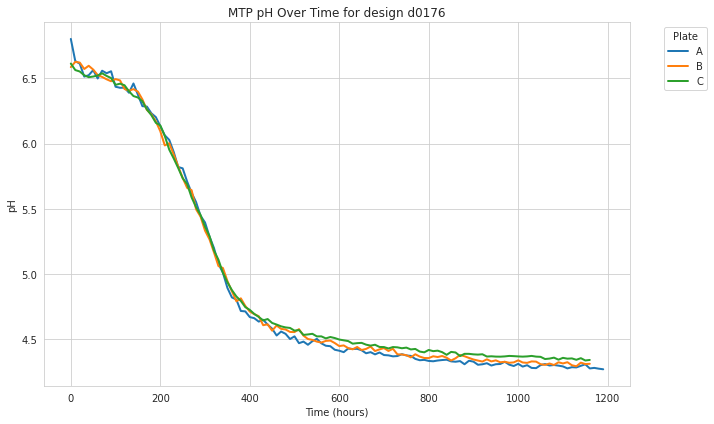

In [15]:
a_random_design = mtp_ph_data.design_id.sample(1).values[0]

fig = plot_fermentation_curves(
    mtp_ph_data.loc[lambda d: d["design_id"].eq(a_random_design)],
    title=f"MTP pH Over Time for design {a_random_design}",
    x="time",
    y="ph",
    xlabel="Time (hours)",
    ylabel="pH",
    sample_col="plate",
)

In [16]:
smoothed_mtp_ph_data = smooth_sequential(
    mtp_ph_data.loc[lambda d: d["design_id"].eq(a_random_design)],
    x="time",
    y="ph",
    groupby_col="sample_id",
    stages=[
        ("savgol", {"window_length": 7, "polyorder": 2}),
        ("rolling", {"window_size": 5}),
        ("rolling", {"window_size": 3}),
    ],
)

evaluate_smoothing_quality(
    smoothed_mtp_ph_data,
    x_col="time",
    smoothed_col="ph_smooth",
    original_col="ph",
    group_col="sample_id",
)

,sample_id,ph_smoothness,ph_smooth_smoothness,ph_ph_smooth_rmse_fit,ph_ph_smooth_r2_fit
0,s103,1.423387,1.000114,0.016554,0.999582
1,s220,1.196523,1.000268,0.011561,0.999785
2,s55,1.453618,1.003482,0.023713,0.999168


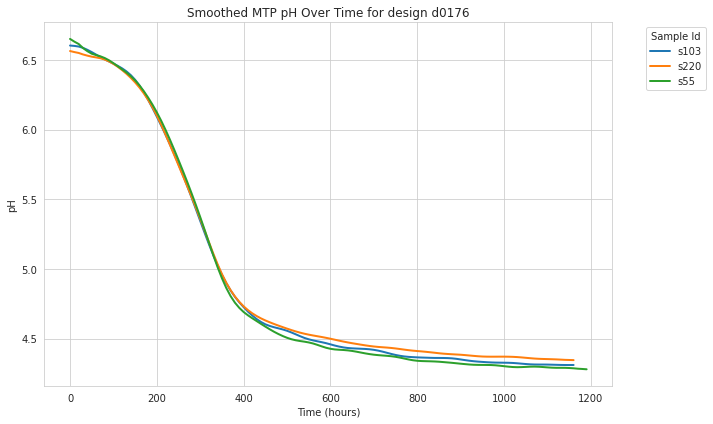

In [17]:
fig = plot_fermentation_curves(
    smoothed_mtp_ph_data,
    title=f"Smoothed MTP pH Over Time for design {a_random_design}",
    x="time",
    y="ph_smooth",
    xlabel="Time (hours)",
    ylabel="pH",
)